# **Data Loading and Preprocessing**

In [2]:
# Import necessary libraries
print("Importing necessary libraries...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping



# Load the dataset
print("\nLoading the dataset...")
file_path = 'merged_hdb_resale_data.csv'  # Update this with your file path
data = pd.read_csv(file_path)
print(f"Dataset loaded with {len(data)} rows and {len(data.columns)} columns.")
print("Sample of the dataset:")
print(data.head())

# Convert the 'month' column to datetime format
print("\nConverting the 'month' column to datetime format...")
data['month'] = pd.to_datetime(data['month'], format='%Y-%m')
print("Conversion successful.")

# Aggregate data: count the number of transactions per month per town
print("\nAggregating data by month and town...")
transaction_count = data.groupby(['month', 'town']).size().reset_index(name='transaction_count')
print(f"Aggregated data has {len(transaction_count)} rows and {len(transaction_count.columns)} columns.")

# Display a sample of the aggregated data
print("Sample of the aggregated data:")
print(transaction_count.head())

# Helper function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}")
    print("-" * 30)
    return mae, rmse, mape


print("\nData loading and preprocessing complete.")


Importing necessary libraries...

Loading the dataset...


<ipython-input-2-4d7866466ce2>:24: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Dataset loaded with 944189 rows and 11 columns.
Sample of the dataset:
     month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
3  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     07 TO 09   
4  1990-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  \
0            31.0        IMPROVED                 1977        9000.0   
1            31.0        IMPROVED                 1977        6000.0   
2            31.0        IMPROVED                 1977        8000.0   
3            31.0        IMPROVED                 1977        6000.0   
4            73.0  NEW GENERATION                 1976       47200.0   

  remaining_lease  
0             NaN  
1             NaN

# **XGBoost Model**

In [5]:
import pandas as pd

# Store results for each combination
xgb_results = []

# Define lag combinations to test
lag_combinations = [
    [1],         # Lag 1
    [1, 3],      # Lags 1, 3
    [1, 3, 6],   # Lags 1, 3, 6
    [1, 3, 6, 12] # Lags 1, 3, 6, 12
]

best_xgb_rmse = float('inf')
best_xgb_mae = float('inf')
best_xgb_mape = float('inf')
best_xgb_model = None
best_xgb_lag = None
best_xgb_params = None

for lags in lag_combinations:
    # Generate lagged features
    temp_data = transaction_count.copy()
    for lag in lags:
        temp_data[f'lag_{lag}'] = temp_data['transaction_count'].shift(lag)
    temp_data = temp_data.dropna()

    # One-Hot Encoding for categorical data
    temp_data = pd.get_dummies(temp_data, columns=['town'])

    # Train-Test Split (80-20)
    train_size = int(len(temp_data) * 0.8)
    train, test = temp_data[:train_size], temp_data[train_size:]

    # Features and Target
    X_train = train.drop(['transaction_count', 'month'], axis=1)
    y_train = train['transaction_count']
    X_test = test.drop(['transaction_count', 'month'], axis=1)
    y_test = test['transaction_count']

    # XGBoost with Grid Search
    xgb_model = xgb.XGBRegressor()
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
    grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search_xgb.fit(X_train, y_train)

    # Get best parameters
    best_params = grid_search_xgb.best_params_
    xgb_pred = grid_search_xgb.predict(X_test)
    xgb_mae, xgb_rmse, xgb_mape = evaluate_model(y_test, xgb_pred, f"XGBoost (lags {lags})")

    # Save results to the list
    xgb_results.append({
        "lags": lags,
        "n_estimators": best_params['n_estimators'],
        "learning_rate": best_params['learning_rate'],
        "max_depth": best_params['max_depth'],
        "subsample": best_params['subsample'],
        "MAE": xgb_mae,
        "RMSE": xgb_rmse,
        "MAPE": xgb_mape
    })

    # Check if the current model is the best
    if xgb_mae < best_xgb_mae:
        best_xgb_rmse = xgb_rmse
        best_xgb_mae = xgb_mae
        best_xgb_mape = xgb_mape
        best_xgb_model = grid_search_xgb.best_estimator_
        best_xgb_lag = lags
        best_xgb_params = best_params

print(f"\nBest XGBoost Model Lag Combination: {best_xgb_lag}")
print(f"Best XGBoost Hyperparameters: {best_xgb_params}")
print(f"Best XGBoost Model RMSE: {best_xgb_rmse}")
print(f"Best XGBoost Model MAE: {best_xgb_mae}")
print(f"Best XGBoost Model MAPE: {best_xgb_mape}")

# Save the best model
joblib.dump(best_xgb_model, "best_xgb_model.pkl")
print("Best XGBoost model saved as 'best_xgb_model.pkl'")





XGBoost (lags [1]) Performance:
  MAE: 27.806934356689453
  RMSE: 41.75655765771258
  MAPE: 0.5432387590408325
------------------------------

XGBoost (lags [1, 3]) Performance:
  MAE: 23.39374351501465
  RMSE: 35.25518890499046
  MAPE: 0.4034796953201294
------------------------------

XGBoost (lags [1, 3, 6]) Performance:
  MAE: 22.472333908081055
  RMSE: 33.99069086425999
  MAPE: 0.37970221042633057
------------------------------

XGBoost (lags [1, 3, 6, 12]) Performance:
  MAE: 23.460357666015625
  RMSE: 34.22486211109458
  MAPE: 0.4677077531814575
------------------------------

Best XGBoost Model Lag Combination: [1, 3, 6]
Best XGBoost Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Model RMSE: 33.99069086425999
Best XGBoost Model MAE: 22.472333908081055
Best XGBoost Model MAPE: 0.37970221042633057
Best XGBoost model saved as 'best_xgb_model.pkl'


# **ARIMA Model**

In [6]:
# Aggregate transaction count for ARIMA (monthly aggregation)
print("Aggregating data for ARIMA model...")
agg_data = transaction_count.groupby('month')['transaction_count'].sum()

# Train-test split (80-20)
train_size = int(len(agg_data) * 0.8)
agg_train, agg_test = agg_data[:train_size], agg_data[train_size:]

print(f"ARIMA Training set size: {len(agg_train)}, Testing set size: {len(agg_test)}")

# Hyperparameter ranges for ARIMA
p = range(0, 5)  # AR order
d = range(0, 2)  # Differencing
q = range(0, 5)  # MA order

# Generate all parameter combinations
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_arima_model = None

print("Performing Grid Search for ARIMA...")

for order in pdq:
    try:
        arima_model = ARIMA(agg_train, order=order)
        arima_fit = arima_model.fit()
        aic = arima_fit.aic
        print(f"ARIMA{order} - AIC: {aic}")

        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_arima_model = arima_fit
            print(f"New best model found: ARIMA{order} with AIC {aic}")

    except Exception as e:
        print(f"Failed to fit ARIMA{order}: {e}")
        continue

print(f"\nBest ARIMA model order: {best_order} with AIC: {best_aic}")

# Forecast and evaluate
arima_pred = best_arima_model.forecast(steps=len(agg_test))
arima_mae, arima_rmse, arima_mape = evaluate_model(agg_test, arima_pred, "Best Grid Search ARIMA")

# Save the best ARIMA model
joblib.dump(best_arima_model, "arima_best_model.pkl")
print("Best ARIMA model from grid search saved as 'grid_search_arima_best_model.pkl'")


Aggregating data for ARIMA model...
ARIMA Training set size: 337, Testing set size: 85
Performing Grid Search for ARIMA...
ARIMA(0, 0, 0) - AIC: 5581.184078582933
New best model found: ARIMA(0, 0, 0) with AIC 5581.184078582933


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(0, 0, 1) - AIC: 5283.002732512127
New best model found: ARIMA(0, 0, 1) with AIC 5283.002732512127


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 2) - AIC: 5138.654943847377
New best model found: ARIMA(0, 0, 2) with AIC 5138.654943847377


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

ARIMA(0, 0, 3) - AIC: 5012.193075670981
New best model found: ARIMA(0, 0, 3) with AIC 5012.193075670981
ARIMA(0, 0, 4) - AIC: 4979.987542842985
New best model found: ARIMA(0, 0, 4) with AIC 4979.987542842985
ARIMA(0, 1, 0) - AIC: 4824.73872462309
New best model found: ARIMA(0, 1, 0) with AIC 4824.73872462309
ARIMA(0, 1, 1) - AIC: 4806.259178338352
New best model found: ARIMA(0, 1, 1) with AIC 4806.259178338352
ARIMA(0, 1, 2) - AIC: 4803.753822536844
New best model found: ARIMA(0, 1, 2) with AIC 4803.753822536844


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(0, 1, 3) - AIC: 4805.403482764321
ARIMA(0, 1, 4) - AIC: 4805.568894263453
ARIMA(1, 0, 0) - AIC: 4835.942536870278


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(1, 0, 1) - AIC: 4821.689391408854
ARIMA(1, 0, 2) - AIC: 4818.011751201439


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(1, 0, 3) - AIC: 4818.932065475822


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 4) - AIC: 4820.182713608777
ARIMA(1, 1, 0) - AIC: 4803.693911674181
New best model found: ARIMA(1, 1, 0) with AIC 4803.693911674181
ARIMA(1, 1, 1) - AIC: 4805.662009376842


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(1, 1, 2) - AIC: 4805.604426405082
ARIMA(1, 1, 3) - AIC: 4805.913677674906


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(1, 1, 4) - AIC: 4806.978529483179
ARIMA(2, 0, 0) - AIC: 4819.008082882914


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(2, 0, 1) - AIC: 4820.8722372177335


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) - AIC: 4819.369156282408


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3) - AIC: 4819.596477549521


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 4) - AIC: 4821.367684379892
ARIMA(2, 1, 0) - AIC: 4805.643592848712
ARIMA(2, 1, 1) - AIC: 4807.201077911375


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(2, 1, 2) - AIC: 4800.581727969107
New best model found: ARIMA(2, 1, 2) with AIC 4800.581727969107


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 3) - AIC: 4800.744599388865


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 4) - AIC: 4804.602276012303
ARIMA(3, 0, 0) - AIC: 4820.735860966975


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(3, 0, 1) - AIC: 4822.999161283247


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 2) - AIC: 4814.777997879068


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 3) - AIC: 4813.240045984394


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA(3, 0, 4) - AIC: 4814.993279880949
ARIMA(3, 1, 0) - AIC: 4803.85713666632


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(3, 1, 1) - AIC: 4804.926888064304


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 2) - AIC: 4800.144268731077
New best model found: ARIMA(3, 1, 2) with AIC 4800.144268731077


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA(3, 1, 3) - AIC: 4800.00992488323
New best model found: ARIMA(3, 1, 3) with AIC 4800.00992488323


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

ARIMA(3, 1, 4) - AIC: 4799.070210336944
New best model found: ARIMA(3, 1, 4) with AIC 4799.070210336944
ARIMA(4, 0, 0) - AIC: 4817.418172894778


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 1) - AIC: 4818.919599342413


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 2) - AIC: 4820.9235704214825


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 3) - AIC: 4822.913009044348


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA(4, 0, 4) - AIC: 4816.818113654097
ARIMA(4, 1, 0) - AIC: 4804.640200046169
ARIMA(4, 1, 1) - AIC: 4801.703226784204


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA(4, 1, 2) - AIC: 4803.656358298413


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA(4, 1, 3) - AIC: 4800.953482844494
ARIMA(4, 1, 4) - AIC: 4800.916836395654

Best ARIMA model order: (3, 1, 4) with AIC: 4799.070210336944

Best Grid Search ARIMA Performance:
  MAE: 844.3036715633392
  RMSE: 894.33512818922
  MAPE: 0.43659974112264477
------------------------------
Best ARIMA model from grid search saved as 'grid_search_arima_best_model.pkl'


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
# Sliding Window Data Preparation
def create_sliding_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Set window size (number of months to look back)
window_size = 12  # Use past 12 months to predict the next month

# Prepare sliding window data for training and testing
transaction_series = transaction_count['transaction_count'].values
X, y = create_sliding_windows(transaction_series, window_size)

# Split data into train and test sets (80-20)
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

print(f"Training data shape: {X_train_lstm.shape}, Testing data shape: {X_test_lstm.shape}")

# LSTM Model
def create_and_train_lstm(X_train, y_train, units=50, dropout_rate=0.2, batch_size=32, epochs=25):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Early Stopping
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        verbose=1, callbacks=[early_stopping], validation_split=0.1)
    return model, history

# Hyperparameter combinations
param_grid_lstm = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [25, 50]
}

best_rmse = float('inf')
best_mae = float('inf')
best_mape = float('inf')
best_model = None
best_params = None

# Manual Grid Search
print("\nPerforming Manual Grid Search for LSTM with Sliding Windows...")
for units in param_grid_lstm['units']:
    for dropout_rate in param_grid_lstm['dropout_rate']:
        for batch_size in param_grid_lstm['batch_size']:
            for epochs in param_grid_lstm['epochs']:
                print(f"Training LSTM with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")
                try:
                    model, history = create_and_train_lstm(X_train_lstm, y_train, units, dropout_rate, batch_size, epochs)
                    lstm_pred = model.predict(X_test_lstm).flatten()

                    # Evaluate the model
                    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
                    lstm_mae = mean_absolute_error(y_test, lstm_pred)
                    lstm_mape = mean_absolute_percentage_error(y_test, lstm_pred)

                    print(f"RMSE: {lstm_rmse}, MAE: {lstm_mae}, MAPE: {lstm_mape}")

                    # Update the best model if performance improves
                    if lstm_rmse < best_rmse:
                        best_rmse = lstm_rmse
                        best_mae = lstm_mae
                        best_mape = lstm_mape
                        best_model = model
                        best_params = (units, dropout_rate, batch_size, epochs)
                except Exception as e:
                    print(f"Error during LSTM training: {str(e)}")

print("\nBest LSTM Model:")
print(f"Units: {best_params[0]}, Dropout Rate: {best_params[1]}, Batch Size: {best_params[2]}, Epochs: {best_params[3]}")
print(f"Best RMSE: {best_rmse}")
print(f"Best MAE: {best_mae}")
print(f"Best MAPE: {best_mape}")

# Save the best LSTM model
best_model.save("best_lstm_model.h5")
print("Best LSTM model saved as 'best_lstm_model.h5'")

Training data shape: (8450, 12, 1), Testing data shape: (2113, 12, 1)

Performing Manual Grid Search for LSTM with Sliding Windows...
Training LSTM with units=50, dropout_rate=0.2, batch_size=32, epochs=25
Epoch 1/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 14649.1104 - val_loss: 2996.3044
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 10779.3242 - val_loss: 2140.5056
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9689.6426 - val_loss: 1645.1384
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8830.4404 - val_loss: 1397.5391
Epoch 5/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7800.9932 - val_loss: 1283.5985
Epoch 6/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6704.6973 - val_loss: 1271.8599
Epoch 7/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6974.2510 - val_loss: 1324.2181
Epoch 8/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6320.8301 - val_loss: 1393.5818
Epoch 9/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 14409.9307 - val_loss: 3105.5625
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 11743.6895 - val_loss: 2251.0312
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9647.8135 - val_loss: 1747.5864
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8392.2432 - val_loss: 1462.5504
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7858.6318 - val_loss: 1313.9706
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7627.4321 - val_loss: 1268.1914
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6954.3486 - val_loss: 1307.5627
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6463.7598 - val_loss: 1390.3389
Epoch 9/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6202.6050 - val_loss: 1359.2700
Epoch 10/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6329.3569 - val_loss: 1426.6715
Epoch 11/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5903.4297 - val_loss: 141

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 15206.2295 - val_loss: 4067.7520
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 12869.1689 - val_loss: 3170.0557
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11956.2402 - val_loss: 2640.4524
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10590.9502 - val_loss: 2248.7642
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9845.8271 - val_loss: 1949.6984
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9287.0967 - val_loss: 1721.3511
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8491.9824 - val_loss: 1553.6611
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8564.3447 - val_loss: 1436.4604
Epoch 9/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7776.7339 - val_loss: 1356.7375
Epoch 10/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7746.0586 - val_loss: 1287.3274
Epoch 11/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7267.9395 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 14899.9043 - val_loss: 3881.4468
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 12822.0664 - val_loss: 3182.7524
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 12189.6553 - val_loss: 2730.2771
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11061.6084 - val_loss: 2332.6938
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10575.6719 - val_loss: 2029.5582
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9374.4287 - val_loss: 1796.4648
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8582.5869 - val_loss: 1618.4028
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9027.9434 - val_loss: 1488.7355
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8449.3623 - val_loss: 1398.7344
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8084.6689 - val_loss: 1326.5365
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7561.1050 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 13418.0488 - val_loss: 3151.0938
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11450.9473 - val_loss: 2289.8008
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10172.5996 - val_loss: 1771.5983
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9120.7607 - val_loss: 1474.1068
Epoch 5/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7875.9395 - val_loss: 1318.3759
Epoch 6/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7444.6104 - val_loss: 1248.4294
Epoch 7/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6899.1362 - val_loss: 1289.8372
Epoch 8/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6535.6396 - val_loss: 1299.8650
Epoch 9/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6620.2124 - val_loss: 1368.6735
Epoch 10/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6003.4229 - val_loss: 1252.2698
Epoch 11/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5938.8345 - val_loss: 136

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 13835.1875 - val_loss: 3070.8352
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11293.0820 - val_loss: 2218.8828
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9963.0537 - val_loss: 1704.0952
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8664.2988 - val_loss: 1424.5502
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8082.7612 - val_loss: 1288.0197
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7050.8325 - val_loss: 1254.6831
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6874.5669 - val_loss: 1284.7803
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6558.0371 - val_loss: 1302.0128
Epoch 9/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6427.7783 - val_loss: 1426.4795
Epoch 10/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6028.4375 - val_loss: 1426.0203
Epoch 11/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6122.8872 - val_loss: 1533

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 14415.8340 - val_loss: 3850.6216
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13056.0498 - val_loss: 3035.4534
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11082.8857 - val_loss: 2560.8101
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10256.5898 - val_loss: 2201.6187
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10094.2461 - val_loss: 1919.3420
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9086.9307 - val_loss: 1704.6000
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8536.8906 - val_loss: 1545.6552
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8273.6230 - val_loss: 1433.5049
Epoch 9/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8399.8486 - val_loss: 1353.8220
Epoch 10/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7798.1997 - val_loss: 1283.4889
Epoch 11/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7463.1396 - val_loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 14936.3076 - val_loss: 3940.0879
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 12762.0771 - val_loss: 3140.0981
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 11683.2412 - val_loss: 2633.9514
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 10410.9658 - val_loss: 2263.4880
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10339.1133 - val_loss: 1974.2428
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9759.6592 - val_loss: 1751.3462
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8747.3350 - val_loss: 1582.0756
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8430.3066 - val_loss: 1460.8428
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8549.4902 - val_loss: 1379.9282
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7888.1650 - val_loss: 1306.8245
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7756.5122 - val_loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 13510.9375 - val_loss: 2156.7488
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9302.4863 - val_loss: 1422.2484
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7776.9160 - val_loss: 1280.7279
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6865.6445 - val_loss: 1433.4893
Epoch 5/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6619.0063 - val_loss: 1611.7820
Epoch 6/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6035.2856 - val_loss: 1721.1276
Epoch 7/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5933.8652 - val_loss: 1692.8805
Epoch 8/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5507.4526 - val_loss: 1501.8965
Epoch 9/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5583.1084 - val_loss: 1747.2416
Epoch 10/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5296.0898 - val_loss: 1265.0697
Epoch 11/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4951.6494 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 13573.8643 - val_loss: 2088.1821
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 9448.1152 - val_loss: 1402.5203
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8035.2065 - val_loss: 1283.2631
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6411.2349 - val_loss: 1352.1068
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6063.7451 - val_loss: 1416.9479
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6040.5962 - val_loss: 1549.1410
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5529.7798 - val_loss: 1575.1119
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5109.6909 - val_loss: 1378.3459
Epoch 9/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5321.1650 - val_loss: 1227.6498
Epoch 10/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5228.6953 - val_loss: 1182.5532
Epoch 11/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4923.0659 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 14902.4287 - val_loss: 2927.2109
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 11067.3525 - val_loss: 2061.7695
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9641.1318 - val_loss: 1611.2877
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8112.5957 - val_loss: 1388.2062
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7424.3569 - val_loss: 1305.8306
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7007.4033 - val_loss: 1291.9293
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6664.7500 - val_loss: 1350.9216
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6511.6089 - val_loss: 1435.3319
Epoch 9/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6656.6831 - val_loss: 1515.0244
Epoch 10/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6246.7910 - val_loss: 1540.2234
Epoch 11/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6229.0234 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 14296.6924 - val_loss: 3015.1309
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 10427.4922 - val_loss: 2148.8474
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9434.0986 - val_loss: 1670.0466
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8570.3340 - val_loss: 1418.3951
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8030.3003 - val_loss: 1314.3883
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6696.1670 - val_loss: 1282.0051
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6676.9316 - val_loss: 1314.6473
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6557.8867 - val_loss: 1392.2148
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6044.1553 - val_loss: 1383.7821
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6046.8081 - val_loss: 1409.8434
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5795.1240 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 13937.1230 - val_loss: 2275.4736
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 9647.4756 - val_loss: 1477.0250
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7580.1489 - val_loss: 1292.5558
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7018.9819 - val_loss: 1355.6510
Epoch 5/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6438.7319 - val_loss: 1417.2437
Epoch 6/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6312.0088 - val_loss: 1486.6501
Epoch 7/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5805.3091 - val_loss: 1436.4231
Epoch 8/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5634.9907 - val_loss: 1568.6350
Epoch 9/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5430.7144 - val_loss: 1553.0609
Epoch 10/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5299.3970 - val_loss: 1243.8420
Epoch 11/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5039.9741 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 13146.6650 - val_loss: 2023.7628
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9273.1875 - val_loss: 1379.7628
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7295.4805 - val_loss: 1294.0740
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 6478.1333 - val_loss: 1373.9196
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6310.0205 - val_loss: 1420.3856
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5803.2803 - val_loss: 1425.3827
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 5365.3052 - val_loss: 1396.7006
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5160.3887 - val_loss: 1233.9325
Epoch 9/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5420.1147 - val_loss: 1232.2877
Epoch 10/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4875.9243 - val_loss: 1281.6362
Epoch 11/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4818.8760 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 14019.9238 - val_loss: 2834.2922
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 10961.8730 - val_loss: 2032.2269
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 9189.3906 - val_loss: 1595.0951
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8628.3252 - val_loss: 1381.1865
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7380.3228 - val_loss: 1299.0614
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7047.4287 - val_loss: 1284.1235
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6627.5332 - val_loss: 1305.8478
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6614.7852 - val_loss: 1358.8884
Epoch 9/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6670.0981 - val_loss: 1385.4830
Epoch 10/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6080.2148 - val_loss: 1358.9310
Epoch 11/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5629.1816 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 13636.1543 - val_loss: 2861.7439
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 10802.6768 - val_loss: 2075.3601
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9580.5996 - val_loss: 1615.2595
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8459.4629 - val_loss: 1388.8416
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 7802.9917 - val_loss: 1297.2010
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 7193.1216 - val_loss: 1279.2585
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6422.0977 - val_loss: 1317.2606
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6580.0854 - val_loss: 1371.7135
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 6233.3726 - val_loss: 1432.8911
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6253.1450 - val_loss: 1468.4690
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6151.6138 - val_

RMSE: 48.06558832730543, MAE: 35.48141098022461, MAPE: 1.2397581338882446

Best LSTM Model:
Units: 100, Dropout Rate: 0.2, Batch Size: 32, Epochs: 50
Best RMSE: 39.85026294808166
Best MAE: 28.268978118896484
Best MAPE: 1.0458866357803345
Best LSTM model saved as 'best_lstm_model.h5'


# **Model Comparison and Best Model Selection**

In [10]:
# Determine the best model based on RMSE, MAE, and MAPE
results = [
    ("XGBoost", xgb_rmse, xgb_mae, xgb_mape),
    ("LSTM", lstm_rmse, lstm_mae, lstm_mape),
    ("ARIMA", arima_rmse, arima_mae, arima_mape)
]

# Find the best model based on RMSE
best_model = min(results, key=lambda x: x[1])
print(f"\nBest Model: {best_model[0]} with RMSE: {best_model[1]}, MAE: {best_model[2]}, MAPE: {best_model[3]}")

# Save the best model name to a file for later use
with open("best_model_name.txt", "w") as f:
    f.write(best_model[0])



Best Model: XGBoost with RMSE: 34.22486211109458, MAE: 23.460357666015625, MAPE: 0.4677077531814575


# **Forecasting and Plotting using Best Model**

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


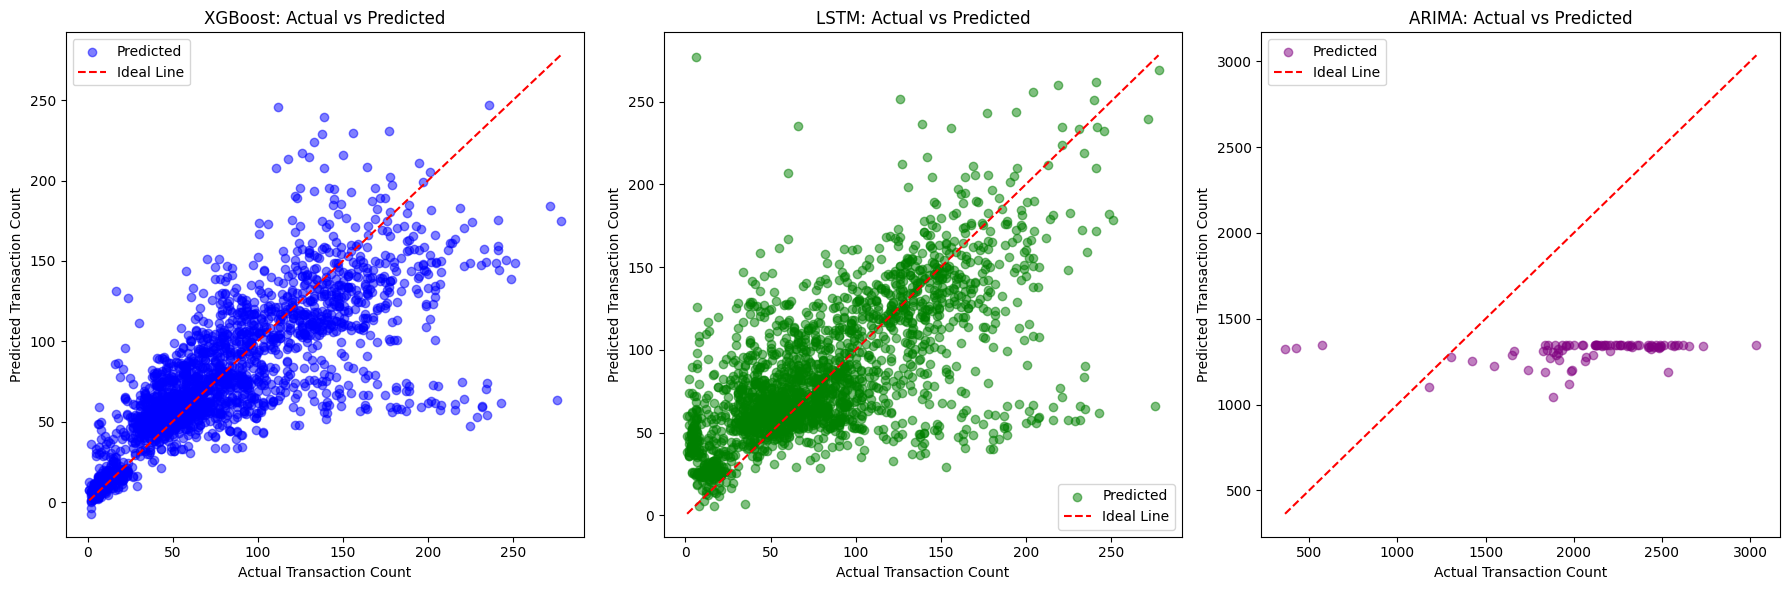

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import tensorflow as tf

# Load XGBoost model and make predictions
xgb_model = joblib.load("best_xgb_model.pkl")
model_features = xgb_model.get_booster().feature_names
X_test_aligned = X_test[model_features]
xgb_pred = xgb_model.predict(X_test_aligned)

# Load LSTM model and make predictions
lstm_model = load_model("best_lstm_model.h5", custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
# Reshape X_test_lstm using sliding window approach
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)).astype(np.float32)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# Load ARIMA model and make predictions
arima_model = joblib.load("arima_best_model.pkl")
arima_pred = arima_model.forecast(steps=len(agg_test))

# Create scatter plots for all models
plt.figure(figsize=(18, 6))

# XGBoost Scatter Plot
plt.subplot(1, 3, 1)
plt.scatter(y_test, xgb_pred, alpha=0.5, color='blue', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Transaction Count')
plt.ylabel('Predicted Transaction Count')
plt.legend()

# LSTM Scatter Plot
plt.subplot(1, 3, 2)
plt.scatter(y_test, lstm_pred, alpha=0.5, color='green', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Actual Transaction Count')
plt.ylabel('Predicted Transaction Count')
plt.legend()

# ARIMA Scatter Plot
plt.subplot(1, 3, 3)
plt.scatter(agg_test, arima_pred, alpha=0.5, color='purple', label='Predicted')
plt.plot([min(agg_test), max(agg_test)], [min(agg_test), max(agg_test)], color='red', linestyle='--', label='Ideal Line')
plt.title('ARIMA: Actual vs Predicted')
plt.xlabel('Actual Transaction Count')
plt.ylabel('Predicted Transaction Count')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


# **Random Forest Model(not in use)**

In [ ]:
'''best_rf_mse = float('inf')
best_rf_rmse = float('inf')
best_rf_mae = float('inf')
best_rf_model = None
best_rf_lag = None

for lags in lag_combinations:
    print(f"\nRandom Forest - Testing lag combination: {lags}")
    temp_data = transaction_count.copy()
    for lag in lags:
        temp_data[f'lag_{lag}'] = temp_data['transaction_count'].shift(lag)
    temp_data = temp_data.dropna()

    # One-Hot Encoding for categorical data
    temp_data = pd.get_dummies(temp_data, columns=['town'])

    # Train-Test Split (80-20)
    train_size = int(len(temp_data) * 0.8)
    train, test = temp_data[:train_size], temp_data[train_size:]

    # Features and Target
    X_train = train.drop(['transaction_count', 'month'], axis=1)
    y_train = train['transaction_count']
    X_test = test.drop(['transaction_count', 'month'], axis=1)
    y_test = test['transaction_count']

    # Random Forest with Grid Search
    rf_model = RandomForestRegressor()
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search_rf.fit(X_train, y_train)

    print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
    rf_pred = grid_search_rf.predict(X_test)
    rf_mse, rf_rmse, rf_mae = evaluate_model(y_test, rf_pred, "Random Forest")

    # Check if the current model is the best
    if rf_mae < best_rf_mae:
        best_rf_mse = rf_mse
        best_rf_rmse = rf_rmse
        best_rf_mae = rf_mae
        best_rf_model = grid_search_rf.best_estimator_
        best_rf_lag = lags

print(f"Best Random Forest Model Lag Combination: {best_rf_lag}")
print(f"Best Random Forest Model MSE: {best_rf_mse}")
print(f"Best Random Forest Model RMSE: {best_rf_rmse}")
print(f"Best Random Forest Model MAE: {best_rf_mae}")

# Save the best model
joblib.dump(best_rf_model, "best_rf_model.pkl")
print("Best Random Forest model saved as 'best_rf_model.pkl'")'''
